<a href="https://colab.research.google.com/github/ustcsteve/XGBoost-Use-Guide/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step1: Install XGBoost

In [1]:
%pip install xgboost

In [2]:
# check xgboost version
import xgboost
print(xgboost.__version__)

0.90


Current version is 0.90. 

Step2. Import dataset

Data Set Information:
Biomedical data set built by Dr. Henrique da Mota during a medical residence period in the Group of Applied Research in Orthopaedics (GARO) of the Centre MÃ©dico-Chirurgical de RÃ©adaptation des Massues, Lyon, France. The data have been organized in two different but related classification tasks. The first task consists in classifying patients as belonging to one out of three categories: Normal (100 patients), Disk Hernia (60 patients) or Spondylolisthesis (150 patients). For the second task, the categories Disk Hernia and Spondylolisthesis were merged into a single category labelled as 'abnormal'. Thus, the second task consists in classifying patients as belonging to one out of two categories: Normal (100 patients) or Abnormal (210 patients). We provide files also for use within the WEKA environment.

Attribute Information:
Each patient is represented in the data set by six biomechanical attributes derived from the shape and orientation of the pelvis and lumbar spine (in this order): pelvic incidence, pelvic tilt, lumbar lordosis angle, sacral slope, pelvic radius and grade of spondylolisthesis. The following convention is used for the class labels: DH (Disk Hernia), Spondylolisthesis (SL), Normal (NO) and Abnormal (AB).

http://archive.ics.uci.edu/ml/datasets/vertebral+column

In [3]:
import requests, zipfile, io
import pandas as pd
from scipy.io import arff


In [ ]:
f_zip = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00212/vertebral_column_data.zip'
r = requests.get(f_zip, stream=True)
Vertebral_zip = zipfile.ZipFile(io.BytesIO(r.content))
Vertebral_zip.extractall()

In [ ]:
data = arff.loadarff('column_2C_weka.arff')
df = pd.DataFrame(data[0])

In [ ]:
class_mapper = {b'Abnormal':1,b'Normal':0}
df['class']=df['class'].replace(class_mapper)

In [ ]:
 df.shape

(310, 7)

In [ ]:
 df.columns

Index(['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class'],
      dtype='object')

Step 3. Isolate features from the label for classification

This example is going to use cross validation to show how to use XGBoost in classification analysis using accuracy as the metric.

In [ ]:
X=df[['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
       'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
y = df['class']

In [ ]:
# evaluate xgboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# define the model
model = XGBClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.830 (0.070)


Step 4. Tune XGBoost Hyperparameters

XGBoost is an ensemble of weak tree models. To optimize its performance, its number of trees, tree depth, learning rate, number of samples, number of features may need to adjust.

a. Explore number of trees

>10 0.833 (0.072)
>50 0.832 (0.078)
>100 0.830 (0.070)
>500 0.829 (0.076)
>1000 0.828 (0.078)
>5000 0.824 (0.075)


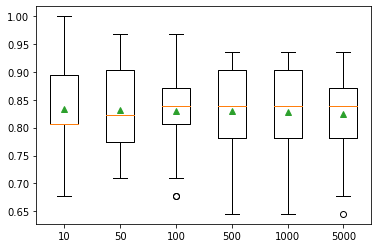

In [ ]:

# explore xgboost number of trees effect on performance

from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	trees = [10, 50, 100, 500, 1000, 5000]
	for n in trees:
		models[str(n)] = XGBClassifier(n_estimators=n)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The best number of trees is 10 that gives an accuracy of 0.833.

b. Explore Tree Depth

>1 0.780 (0.067)
>2 0.802 (0.062)
>3 0.833 (0.072)
>4 0.838 (0.064)
>5 0.845 (0.060)
>6 0.837 (0.062)
>7 0.840 (0.064)
>8 0.838 (0.065)
>9 0.839 (0.061)
>10 0.839 (0.061)


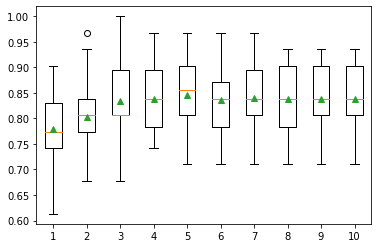

In [ ]:

# explore xgboost number of trees effect on performance

from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(1,11):
		models[str(i)] = XGBClassifier(n_estimators=10, max_depth=i)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The best tree depth wiht 10 trees is 5 that gives an accuracy of 0.845.

c. Explore Learning Rate

>0.0001 0.845 (0.060)
>0.0010 0.845 (0.060)
>0.0100 0.845 (0.060)
>0.1000 0.845 (0.060)
>1.0000 0.845 (0.060)


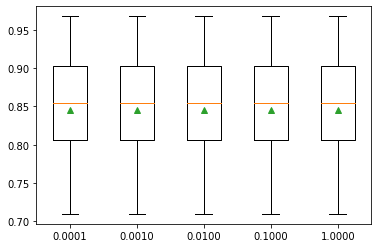

In [ ]:
# get a list of models to evaluate
def get_models():
	models = dict()
	rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
	for r in rates:
		key = '%.4f' % r
		models[key] = XGBClassifier(n_estimators=10, max_depth=5, eta=r)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The model doesn't vary by its learning rate.

d. Explore Number of Samples

>0.1 0.801 (0.061)
>0.2 0.818 (0.061)
>0.3 0.835 (0.054)
>0.4 0.841 (0.059)
>0.5 0.846 (0.058)
>0.6 0.839 (0.071)
>0.7 0.839 (0.065)
>0.8 0.839 (0.070)
>0.9 0.835 (0.067)
>1.0 0.845 (0.060)


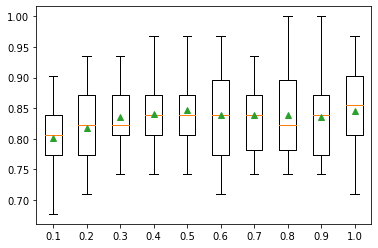

In [ ]:
import numpy as np
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = XGBClassifier(n_estimators=10, max_depth=5, subsample=i)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

When XGBoost randomly samples half of the training set, it gives the best accuracy of 0.846.

e. Explore Number of Features

>0.1 0.703 (0.052)
>0.2 0.703 (0.052)
>0.3 0.703 (0.052)
>0.4 0.765 (0.073)
>0.5 0.818 (0.054)
>0.6 0.818 (0.054)
>0.7 0.815 (0.056)
>0.8 0.815 (0.056)
>0.9 0.837 (0.056)
>1.0 0.846 (0.058)


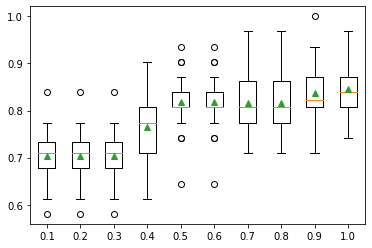

In [ ]:
import numpy as np
# get a list of models to evaluate
def get_models():
	models = dict()
	for i in np.arange(0.1, 1.1, 0.1):
		key = '%.1f' % i
		models[key] = XGBClassifier(n_estimators=10, max_depth=5, subsample=0.5, colsample_bytree=i)
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
  
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The model performs best when all 6 features are used along with 10 trees, 5 tree depth, randomly used 50% data for training with minimal impact from its learning rate. 